# Project: Train a Quadcopter How to Fly

Design an agent to fly a quadcopter, and then train it using a reinforcement learning algorithm (DDPG). 

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you will define your own task in `task.py`.  Although we have provided a example task to get you started, you are encouraged to change it.  Later in this notebook, you will learn more about how to amend this file.

You are welcome to create any additional files to help you to organize your code.  For instance, you may find it useful to define a `model.py` file defining any needed neural network architectures.

## Controlling the Quadcopter

We provide a sample agent in the code cell below to show you how to use the sim to control the quadcopter.  This agent is even simpler than the sample agent that you'll examine (in `agents/policy_search.py`) later in this notebook!

The agent controls the quadcopter by setting the revolutions per second on each of its four rotors.  The provided agent in the `Basic_Agent` class below always selects a random action for each of the four rotors.  These four speeds are returned by the `act` method as a list of four floating-point numbers.  

In [18]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the quadcopter.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the quadcopter.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [19]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Run the code cell below to visualize how the position of the quadcopter evolved during the simulation.

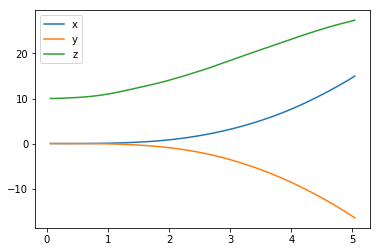

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the quadcopter.

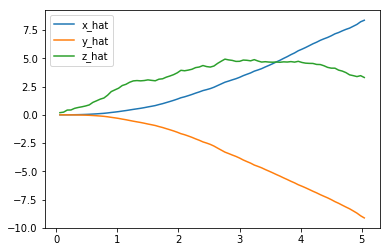

In [21]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, you can plot the Euler angles (the rotation of the quadcopter over the $x$-, $y$-, and $z$-axes),

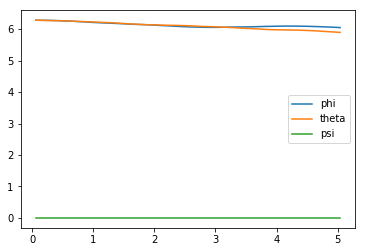

In [22]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

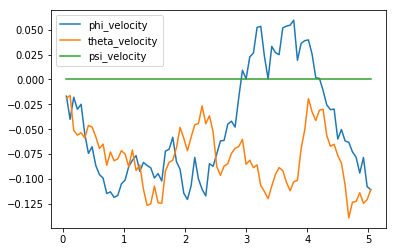

In [23]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

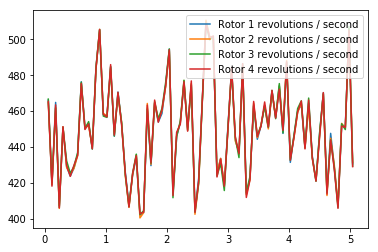

In [24]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the quadcopter in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the quadcopter in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [25]:
# the pose, velocity, and angular velocity of the quadcopter at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[ 14.96752914 -16.51574262  27.38152752   6.04964904   5.89692134   0.        ]
[ 8.36724441 -9.11663363  3.30383681]
[-0.11089114 -0.1106006   0.        ]


In the sample task in `task.py`, we use the 6-dimensional pose of the quadcopter to construct the state of the environment at each timestep.  However, when amending the task for your purposes, you are welcome to expand the size of the state vector by including the velocity information.  You can use any combination of the pose, velocity, and angular velocity - feel free to tinker here, and construct the state to suit your task.

## The Task

A sample task has been provided for you in `task.py`.  Open this file in a new window now. 

The `__init__()` method is used to initialize several variables that are needed to specify the task.  
- The simulator is initialized as an instance of the `PhysicsSim` class (from `physics_sim.py`).  
- Inspired by the methodology in the original DDPG paper, we make use of action repeats.  For each timestep of the agent, we step the simulation `action_repeats` timesteps.  If you are not familiar with action repeats, please read the **Results** section in [the DDPG paper](https://arxiv.org/abs/1509.02971).
- We set the number of elements in the state vector.  For the sample task, we only work with the 6-dimensional pose information.  To set the size of the state (`state_size`), we must take action repeats into account.  
- The environment will always have a 4-dimensional action space, with one entry for each rotor (`action_size=4`). You can set the minimum (`action_low`) and maximum (`action_high`) values of each entry here.
- The sample task in this provided file is for the agent to reach a target position.  We specify that target position as a variable.

The `reset()` method resets the simulator.  The agent should call this method every time the episode ends.  You can see an example of this in the code cell below.

The `step()` method is perhaps the most important.  It accepts the agent's choice of action `rotor_speeds`, which is used to prepare the next state to pass on to the agent.  Then, the reward is computed from `get_reward()`.  The episode is considered done if the time limit has been exceeded, or the quadcopter has travelled outside of the bounds of the simulation.

In the next section, you will learn how to test the performance of an agent on this task.

## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [9]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from task import Task

num_episodes = 1000
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode = 1000, score =  -0.527 (best =   0.258), noise_scale = 3.25

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your quadcopter to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [1]:
# Define the task (Take-off)

import numpy as np
from physics_sim import PhysicsSim

class Task1():
    """Task (environment) that defines the goal and provides feedback to the agent."""
    def __init__(self, init_pose=None, init_velocities=None, 
        init_angle_velocities=None, runtime=5., target_pos=None):
        """Initialize a Task object.
        Params
        ======
            init_pose: initial position of the quadcopter in (x,y,z) dimensions and the Euler angles
            init_velocities: initial velocity of the quadcopter in (x,y,z) dimensions
            init_angle_velocities: initial radians/second for each of the three Euler angles
            runtime: time limit for each episode
            target_pos: target/goal (x,y,z) position for the agent
        """
        # Simulation
        self.sim = PhysicsSim(init_pose, init_velocities, init_angle_velocities, runtime) 
        self.action_repeat = 3

        self.state_size = self.action_repeat * 6
        self.action_low = 0
        self.action_high = 900
        self.action_size = 4

        # Goal
        self.target_pos = target_pos if target_pos is not None else np.array([0., 0., 10.]) 

    def get_reward(self):
        """Uses current pose of sim to return reward."""
        reward_x = 1-.01*(abs(self.sim.pose[0] - self.target_pos[0]))
        reward_y = 1-.01*(abs(self.sim.pose[1] - self.target_pos[1]))
        reward_z = 1-.05*(abs(self.sim.pose[2] - self.target_pos[2]))
        
        reward = (reward_x + reward_y + reward_z)/3
        
        if self.sim.done and self.sim.runtime > self.sim.time:
            reward = -300
                
        return reward

    def step(self, rotor_speeds):
        """Uses action to obtain next state, reward, done."""
        reward = 0
        pose_all = []
        for _ in range(self.action_repeat):
            done = self.sim.next_timestep(rotor_speeds) # update the sim pose and velocities
            reward += self.get_reward() 
            pose_all.append(self.sim.pose)
        next_state = np.concatenate(pose_all)
        return next_state, reward, done

    def reset(self):
        """Reset the sim to start a new episode."""
        self.sim.reset()
        state = np.concatenate([self.sim.pose] * self.action_repeat) 
        return state

In [2]:
# Define the Replay Buffer

import random
from collections import namedtuple, deque

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size: maximum size of buffer
            batch_size: size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self, batch_size=64):
        """Randomly sample a batch of experiences from memory."""
        return random.sample(self.memory, k=self.batch_size)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [3]:
# Define the Actor

from keras import layers, models, optimizers
from keras import backend as K

class Actor:
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, action_low, action_high):
        """Initialize parameters and build model.

        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            action_low (array): Min value of each action dimension
            action_high (array): Max value of each action dimension
        """
        self.state_size = state_size
        self.action_size = action_size
        self.action_low = action_low
        self.action_high = action_high
        self.action_range = self.action_high - self.action_low

        # Initialize any other variables here

        self.build_model()

    def build_model(self):
        """Build an actor (policy) network that maps states -> actions."""
        # Define input layer (states)
        states = layers.Input(shape=(self.state_size,), name='states')

        # Add hidden layers
        net = layers.Dense(units=32, activation='relu')(states)
        net = layers.Dense(units=64, activation='relu')(net)
        net = layers.Dense(units=32, activation='relu')(net)

        # Try different layer sizes, activations, add batch normalization, regularizers, etc.

        # Add final output layer with sigmoid activation
        raw_actions = layers.Dense(units=self.action_size, activation='sigmoid',
            name='raw_actions')(net)

        # Scale [0, 1] output for each action dimension to proper range
        actions = layers.Lambda(lambda x: (x * self.action_range) + self.action_low,
            name='actions')(raw_actions)

        # Create Keras model
        self.model = models.Model(inputs=states, outputs=actions)

        # Define loss function using action value (Q value) gradients
        action_gradients = layers.Input(shape=(self.action_size,))
        loss = K.mean(-action_gradients * actions)

        # Incorporate any additional losses here (e.g. from regularizers)

        # Define optimizer and training function
        optimizer = optimizers.Adam(lr=0.0001)
        updates_op = optimizer.get_updates(params=self.model.trainable_weights, loss=loss)
        self.train_fn = K.function(
            inputs=[self.model.input, action_gradients, K.learning_phase()],
            outputs=[],
            updates=updates_op)

Using TensorFlow backend.


In [4]:
# Define the Critic

class Critic:
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size):
        """Initialize parameters and build model.

        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size

        # Initialize any other variables here

        self.build_model()

    def build_model(self):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        # Define input layers
        states = layers.Input(shape=(self.state_size,), name='states')
        actions = layers.Input(shape=(self.action_size,), name='actions')

        # Add hidden layer(s) for state pathway
        net_states = layers.Dense(units=32, activation='relu')(states)
        net_states = layers.Dense(units=64, activation='relu')(net_states)

        # Add hidden layer(s) for action pathway
        net_actions = layers.Dense(units=32, activation='relu')(actions)
        net_actions = layers.Dense(units=64, activation='relu')(net_actions)

        # Try different layer sizes, activations, add batch normalization, regularizers, etc.

        # Combine state and action pathways
        net = layers.Add()([net_states, net_actions])
        net = layers.Activation('relu')(net)

        # Add more layers to the combined network if needed

        # Add final output layer to prduce action values (Q values)
        Q_values = layers.Dense(units=1, name='q_values')(net)

        # Create Keras model
        self.model = models.Model(inputs=[states, actions], outputs=Q_values)

        # Define optimizer and compile model for training with built-in loss function
        optimizer = optimizers.Adam(lr = 0.0001)
        self.model.compile(optimizer=optimizer, loss='mse')

        # Compute action gradients (derivative of Q values w.r.t. to actions)
        action_gradients = K.gradients(Q_values, actions)

        # Define an additional function to fetch action gradients (to be used by actor model)
        self.get_action_gradients = K.function(
            inputs=[*self.model.input, K.learning_phase()],
            outputs=action_gradients)

In [5]:
# Define the Agent

class DDPG():
    """Reinforcement Learning agent that learns using DDPG."""
    def __init__(self, task):
        self.task = task
        self.state_size = task.state_size
        self.action_size = task.action_size
        self.action_low = task.action_low
        self.action_high = task.action_high

        # Actor (Policy) Model
        self.actor_local = Actor(self.state_size, self.action_size, self.action_low, self.action_high)
        self.actor_target = Actor(self.state_size, self.action_size, self.action_low, self.action_high)

        # Critic (Value) Model
        self.critic_local = Critic(self.state_size, self.action_size)
        self.critic_target = Critic(self.state_size, self.action_size)

        # Initialize target model parameters with local model parameters
        self.critic_target.model.set_weights(self.critic_local.model.get_weights())
        self.actor_target.model.set_weights(self.actor_local.model.get_weights())

        # Noise process
        self.exploration_mu = 0
        self.exploration_theta = 0.1
        self.exploration_sigma = 0.2
        self.noise = OUNoise(self.action_size, self.exploration_mu, self.exploration_theta, self.exploration_sigma)

        # Replay memory
        self.buffer_size = 100000
        self.batch_size = 64
        self.memory = ReplayBuffer(self.buffer_size, self.batch_size)

        # Algorithm parameters
        self.gamma = 0.99  # discount factor
        self.tau = 0.01  # for soft update of target parameters

    def reset_episode(self):
        self.noise.reset()
        state = self.task.reset()
        self.last_state = state
        return state

    def step(self, action, reward, next_state, done):
         # Save experience / reward
        self.memory.add(self.last_state, action, reward, next_state, done)

        # Learn, if enough samples are available in memory
        if len(self.memory) > self.batch_size:
            experiences = self.memory.sample()
            self.learn(experiences)

        # Roll over last state and action
        self.last_state = next_state

    def act(self, state):
        """Returns actions for given state(s) as per current policy."""
        state = np.reshape(state, [-1, self.state_size])
        action = self.actor_local.model.predict(state)[0]
        return list(action + self.noise.sample())  # add some noise for exploration

    def learn(self, experiences):
        """Update policy and value parameters using given batch of experience tuples."""
        # Convert experience tuples to separate arrays for each element (states, actions, rewards, etc.)
        states = np.vstack([e.state for e in experiences if e is not None])
        actions = np.array([e.action for e in experiences if e is not None]).astype(np.float32).reshape(-1, self.action_size)
        rewards = np.array([e.reward for e in experiences if e is not None]).astype(np.float32).reshape(-1, 1)
        dones = np.array([e.done for e in experiences if e is not None]).astype(np.uint8).reshape(-1, 1)
        next_states = np.vstack([e.next_state for e in experiences if e is not None])

        # Get predicted next-state actions and Q values from target models
        #     Q_targets_next = critic_target(next_state, actor_target(next_state))
        actions_next = self.actor_target.model.predict_on_batch(next_states)
        Q_targets_next = self.critic_target.model.predict_on_batch([next_states, actions_next])

        # Compute Q targets for current states and train critic model (local)
        Q_targets = rewards + self.gamma * Q_targets_next * (1 - dones)
        self.critic_local.model.train_on_batch(x=[states, actions], y=Q_targets)

        # Train actor model (local)
        action_gradients = np.reshape(self.critic_local.get_action_gradients([states, actions, 0]), (-1, self.action_size))
        self.actor_local.train_fn([states, action_gradients, 1])  # custom training function

        # Soft-update target models
        self.soft_update(self.critic_local.model, self.critic_target.model)
        self.soft_update(self.actor_local.model, self.actor_target.model)   

    def soft_update(self, local_model, target_model):
        """Soft update model parameters."""
        local_weights = np.array(local_model.get_weights())
        target_weights = np.array(target_model.get_weights())

        assert len(local_weights) == len(target_weights), "Local and target model parameters must have the same size"

        new_weights = self.tau * local_weights + (1 - self.tau) * target_weights
        target_model.set_weights(new_weights)

In [6]:
# Define the Noise Model

import numpy as np
import copy

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu, theta, sigma):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

In [32]:
# Train the DDPG Agent

all_scores = []
num_episodes = 1000
init_pose = np.array([0., 0., 5., 0., 0., 0.])
target_pos = np.array([0., 0., 50.])
task = Task1(init_pose=init_pose,target_pos=target_pos)
agent = DDPG(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    total_reward = 0
    while True:
        action = agent.act(state) 
        # print(action)
        next_state, reward, done = task.step(action)
        agent.step(action,reward,next_state,done)
        state = next_state
        total_reward += reward
        if done:
            all_scores.append(total_reward)
            print("\rEpisode = {:4d}, Total Reward = {:7.3f} (best = {:7.3f}), Final Position = {}".format(
                i_episode, total_reward, np.max(all_scores), task.sim.pose[:3]), end="")
            break
    sys.stdout.flush()

Episode = 1000, Total Reward = 101.509 (best = 167.055), Final Position = [ -3.3209134   -3.17067509  32.02709452]1808256e+01]]

In [13]:
print("Velocity of all 4 rotors for the last timestep of the last episode")
print(action)

Velocity of all 4 rotors for the last timestep of the last episode
[899.45119845870181, 0.057298963791462931, 900.22390283464415, 900.41194979119268]


## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

Text(0.5,1,'Learning of Agent over Time')

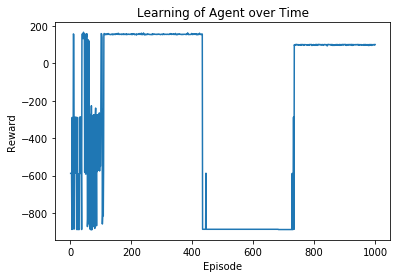

In [33]:
# Plot the rewards (for a single run)

plt.plot(np.arange(1,num_episodes+1),all_scores)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title('Learning of Agent over Time')

## Reflections

**Question 1**: Describe the task that you specified in `task.py`.  How did you design the reward function?

**Answer**:

Among various possible tasks (for e.g., landing, take-off, flying to a given coordinate), the task specified for quadcopter is to **take off from [0,0,5] to [0,0,50] coordinates**. The task was chosen as the solution is intuitive i.e., all rotors' speed should be equal and higher the speed, faster the take-off. Hence, when the agent is trained, the action chosen by the agent can be compared with this solution which would not be possible in other tasks. Further, the initial position of quadcopter is decided to be [0,0,5] rather than an origin as the quadcopter is crashing for most number of episodes and agent could not learn over time with limited computing resources.

*Note that a new class `Task1` is defined in this notebook instead of defining the task in `task.py` file to avoid frequent switching between files.*

To complete the take-off sucessfully, the reward function was designed with following attributes:

- *Small penalty is assigned for swaying away from x,y coordinates* since the ideal take-off would be vertical with no change in x and y coordinates.
- As the quadcopter is *closer to target position, smaller negative reward is given.*
- More weightage is given to "getting closer to target position" as compared to "swaying away from vertical direction".
- Very *high negative reward* is assigned if *quadcopter crashes to floor.*
- Reward for each timestep is *normalized* between -1 to +1.

**Question 2**: Discuss your agent briefly, using the following questions as a guide:

- What learning algorithm(s) did you try? What worked best for you?
- What was your final choice of hyperparameters (such as $\alpha$, $\gamma$, $\epsilon$, etc.)?
- What neural network architecture did you use (if any)? Specify layers, sizes, activation functions, etc.

**Answer**:

In this Quadcopter problem, *both state and action spaces are continuous.* Therefore, the learning algorithm should be chosen accordingly. Descritization of the spaces can be one choice, however, for large/complicated spaces, number of bins will increase and hence the computational cost. Policy-based methods can be a good alternative in continuous RL problems as they directly map states to actions. 

In the quadcopter take-off task, the agent was designed using **Deep Deterministic Policy Gradient (DDPG)** algorithm. It is essentially an actor-critic method in which actor (see class `Actor`) gets feedback from critic (see class `Critic`) at each timestep and subsequently the policy is updated. Also the critic is updated to get an accurate feedback. The DDPG algorithm is implemented here using class `Agent` in which two actor and two critic models are used to decouple parameters being updated from the one providing target values like Deep Q-learning. Soft updates are performed to update the weights of neural net in critic model when agent learns from past experiences. The agent also uses *replay buffer* to avoid the effect of correlation between consecutive experience tuples on training process. Further, to add stochasticity in the actions, Ornstein–Uhlenbeck Noise model (see class `OUNoise`) is implemented.

*Note that the agent is defined in this notebook using class `Agent` and not in the separate file to avoid frequent switching between windows.*

Various values for different hyperparameters were attempted. However, it was concluded that *they do not have a significant impact on learning of DDPG agent* and hence most of the values remain unchanged. Final values for various hyperparameters are as follows:

- Discount factor ($\gamma$) = 0.99
- Learning rate for soft update ($\tau$) = 0.01
- $\mu$ for Gaussian Distribution = 0
- $\theta$ for Gaussian Distribution = 0.1
- $\sigma$ for Gaussian Distribution = 0.2

For actor model, neural network with three hidden layers (32, 64, and 32 neurons each) was used and output layer was equipped with *sigmoid* activation function. Similarly in critic model, neural network had two hidden layers with 32 and 64 neurons and one output layer with *Relu* activation function. 

**Question 3**: Using the episode rewards plot, discuss how the agent learned over time.

- Was it an easy task to learn or hard?
- Was there a gradual learning curve, or an aha moment?
- How good was the final performance of the agent? (e.g. mean rewards over the last 10 episodes)

**Answer**:

From the rewards vs. episode plot, it can be said that the agent has successfully learnt to take-off over the time. Due to many hyperparameters and complex physics, it was not easy to train the agent. Various reward functions and combinations of hyperparameters were attempted which ultimately helped in satisfactory training of the agent.

Initially, due to the exploration, rewards are fluctuating for almost 100 episodes. Soon after agent learns to fly the quadcopter near target because of which positive rewards are obtained. Rather than a gradual learning over time, it seems to have struck the right chord suddenly and it continues to perform well till almost 400 episodes. However, then it started crashing over and over, earning maximum negative reward which continued till next 300 episodes. Then it learnt again to perform well and maintain the better performance till the end of the training.

Ideally, for take-off, speed of all the rotors should be same and maximum to achieve the target swiftly (see discussion in *Question 1*). I check the action taken in the last timestep of last episode (see the output of code cell above the graph) and it can be seen that the agent assigned equal speed to all rotors except the second one. Thus, it can be said that the agent has properly learnt to take-off over the time. Performance in final episode is much better with average total reward of last 10 episodes equal to 101.

**Question 4**: Briefly summarize your experience working on this project. You can use the following prompts for ideas.

- What was the hardest part of the project? (e.g. getting started, plotting, specifying the task, etc.)
- Did you find anything interesting in how the quadcopter or your agent behaved?

**Answer**:

Overall, training the agent to fly the quadcopter was *difficult but not impossible.* The task was to take-off from the given location and reach the target coordinates. Given the complexity of implementing RL in continuous spaces, *how to approach the problem was the most difficult part.* With the help provided in the project through templates for actor, critic, noise model and agent, DDPG was implemented to fly quadcopter. Various combinations of hyperparameters and reward functions were tried and the agent was trained sucessfully to take-off. Quadcopter was crashing sometimes and penalizing it hard was helpful for better training. Also, it might be hovering while taking off but did not pay much attention to that as it was perfectly fine as long as it reaches the target position. At the end of training, the agent was able to earn positive rewards consecutively for last few episodes. *An interesting point is that agent learnt to assign same and maximum speed to all rotors which is intuitive for the swift take-off.* However, *repeatability of the results* remains an issue which might be solved by training the agent for more episodes.